# **2019 November E-Commerce - Analyzing Customers Behavior**

Analyzing Conversion Rate and Drop-off Rate using Funnel Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/포트폴리오 데이터 분석 실습/Funnel Analysis/data/eCommerce Data')
os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/포트폴리오 데이터 분석 실습/Funnel Analysis/data/eCommerce Data'

# **Problem Definition**

1. DAU (Daily Active Users) Trends

    * On which ***day of the week*** and ***hour of the day*** do we observe the highest volume of user visits?

2. Funnel Analysis
    * At which stage of the customer event type (View ➡ Cart ➡ Purchase) shows the highest drop-off rate?
      * This anlaysis will ***only focus on users' sequencial behavior (View ➡ Cart ➡ Purchase)*** and won't include data with users who directly purchased from view.

# **Data Preprocessing**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load Data: Extract unique user_session randomly
sessions = pd.read_csv('2019-Nov.csv', usecols=['user_session']).dropna()
unique_sessions = sessions['user_session'].unique()

sample_size = 200000
sampled_sessions = np.random.choice(unique_sessions, size=sample_size, replace=False)
sampled_sessions_set = set(sampled_sessions)

selected_data=[]

for chunk in pd.read_csv('2019-Nov.csv', chunksize=1000000, usecols=['event_time', 'event_type', 'user_id', 'user_session']):
  filtered_chunk = chunk[chunk['user_session'].isin(sampled_sessions_set)]
  selected_data.append(filtered_chunk)

df = pd.concat(selected_data, ignore_index=True)
df.head()

,event_time,event_type,user_id,user_session
0,2019-11-01 00:00:23 UTC,view,436701163,50de79b1-b0ec-42c0-bbe0-8b5d2dc33e1e
1,2019-11-01 00:01:33 UTC,view,518956209,6764041a-9285-4869-8a32-a79adf31d212
2,2019-11-01 00:02:04 UTC,view,541851324,bd3d2542-e845-48be-989a-0c9bc5ce1bea
3,2019-11-01 00:02:11 UTC,view,518956209,6764041a-9285-4869-8a32-a79adf31d212
4,2019-11-01 00:04:47 UTC,view,566281250,a79171eb-7d81-4536-8623-8f3159da5229


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973624 entries, 0 to 973623
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   event_time    973624 non-null  object
 1   event_type    973624 non-null  object
 2   user_id       973624 non-null  int64 
 3   user_session  973624 non-null  object
dtypes: int64(1), object(3)
memory usage: 29.7+ MB


In [5]:
# Change Data Type: event_time
df['event_time'] = pd.to_datetime(df['event_time'], format='%Y-%m-%d %H:%M:%S UTC')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973624 entries, 0 to 973623
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_time    973624 non-null  datetime64[ns]
 1   event_type    973624 non-null  object        
 2   user_id       973624 non-null  int64         
 3   user_session  973624 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 29.7+ MB


In [6]:
# Add columns: date_ymd, day_of_week, day_of_week1, hour
df['date_ymd'] = df['event_time'].dt.date
df['day_of_week'] = df['event_time'].dt.day_name()
df['day_of_week1'] = df['event_time'].dt.dayofweek
df['hour'] = df['event_time'].dt.hour
df['hour_group'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night(0-6)', 'Morning(6-12)', 'Afternoon(12-18)', 'Evening(18-24)'],
                          include_lowest=True)

df.head()

,event_time,event_type,user_id,user_session,date_ymd,day_of_week,day_of_week1,hour,hour_group
0,2019-11-01 00:00:23,view,436701163,50de79b1-b0ec-42c0-bbe0-8b5d2dc33e1e,2019-11-01,Friday,4,0,Night(0-6)
1,2019-11-01 00:01:33,view,518956209,6764041a-9285-4869-8a32-a79adf31d212,2019-11-01,Friday,4,0,Night(0-6)
2,2019-11-01 00:02:04,view,541851324,bd3d2542-e845-48be-989a-0c9bc5ce1bea,2019-11-01,Friday,4,0,Night(0-6)
3,2019-11-01 00:02:11,view,518956209,6764041a-9285-4869-8a32-a79adf31d212,2019-11-01,Friday,4,0,Night(0-6)
4,2019-11-01 00:04:47,view,566281250,a79171eb-7d81-4536-8623-8f3159da5229,2019-11-01,Friday,4,0,Night(0-6)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973624 entries, 0 to 973623
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_time    973624 non-null  datetime64[ns]
 1   event_type    973624 non-null  object        
 2   user_id       973624 non-null  int64         
 3   user_session  973624 non-null  object        
 4   date_ymd      973624 non-null  object        
 5   day_of_week   973624 non-null  object        
 6   day_of_week1  973624 non-null  int32         
 7   hour          973624 non-null  int32         
 8   hour_group    973624 non-null  category      
dtypes: category(1), datetime64[ns](1), int32(2), int64(1), object(4)
memory usage: 52.9+ MB


In [8]:
df['date_ymd'] = pd.to_datetime(df['date_ymd'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973624 entries, 0 to 973623
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_time    973624 non-null  datetime64[ns]
 1   event_type    973624 non-null  object        
 2   user_id       973624 non-null  int64         
 3   user_session  973624 non-null  object        
 4   date_ymd      973624 non-null  datetime64[ns]
 5   day_of_week   973624 non-null  object        
 6   day_of_week1  973624 non-null  int32         
 7   hour          973624 non-null  int32         
 8   hour_group    973624 non-null  category      
dtypes: category(1), datetime64[ns](2), int32(2), int64(1), object(3)
memory usage: 52.9+ MB


# **EDA (Exploratory Data Analysis)**

## ▶ DAU Trends

In [9]:
# DAU Trends : Day
dau_day = df.groupby(['day_of_week', 'day_of_week1'])['user_id'].nunique().reset_index().rename(columns={'user_id':'dau'})
dau_day.sort_values('day_of_week1', inplace=True)
dau_day

,day_of_week,day_of_week1,dau
1,Monday,0,24572
5,Tuesday,1,23436
6,Wednesday,2,23381
4,Thursday,3,25084
0,Friday,4,33318
2,Saturday,5,35148
3,Sunday,6,29593


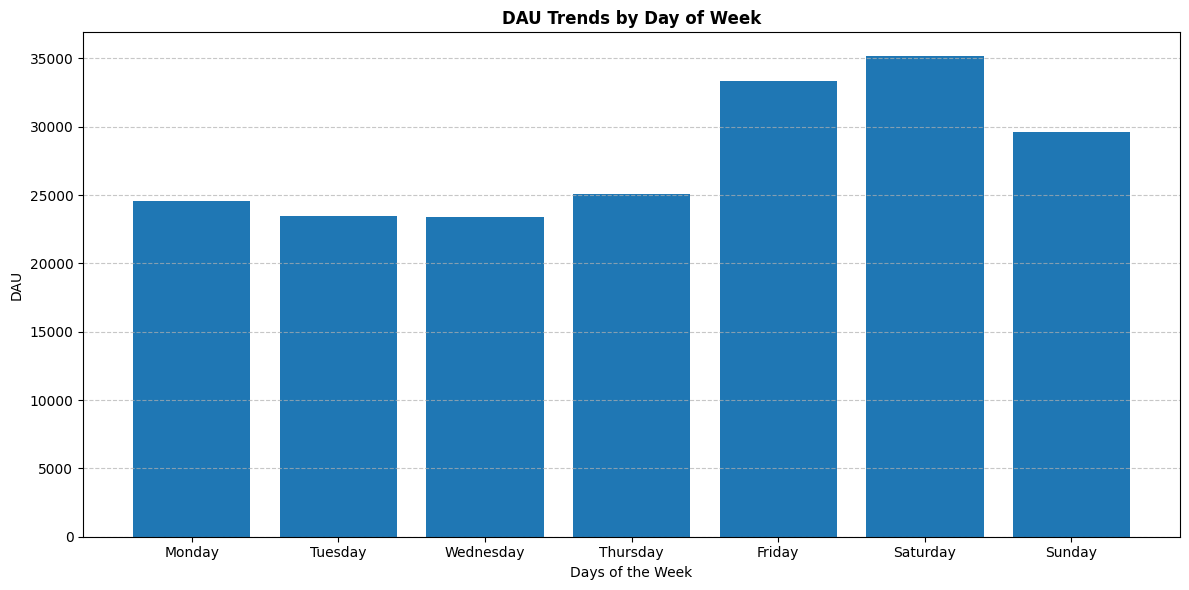

In [10]:
plt.bar(dau_day['day_of_week'], dau_day['dau'])
plt.xlabel('Days of the Week')
plt.ylabel('DAU')
plt.title('DAU Trends by Day of Week', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Saturday records the highest number of customer visits. Customer traffic is relatively high during the weekend.

In [11]:
# DAU Trends : Hour
dau_hour = df.groupby(['day_of_week', 'day_of_week1', 'hour'])['user_id'].nunique().reset_index().rename(columns={'user_id':'dau'})
dau_hour.sort_values('day_of_week1', inplace=True)
dau_hour

,day_of_week,day_of_week1,hour,dau
24,Monday,0,0,186
25,Monday,0,1,348
26,Monday,0,2,662
27,Monday,0,3,1058
28,Monday,0,4,1379
...,...,...,...,...
83,Sunday,6,11,2185
84,Sunday,6,12,2175
85,Sunday,6,13,2163
86,Sunday,6,14,2287


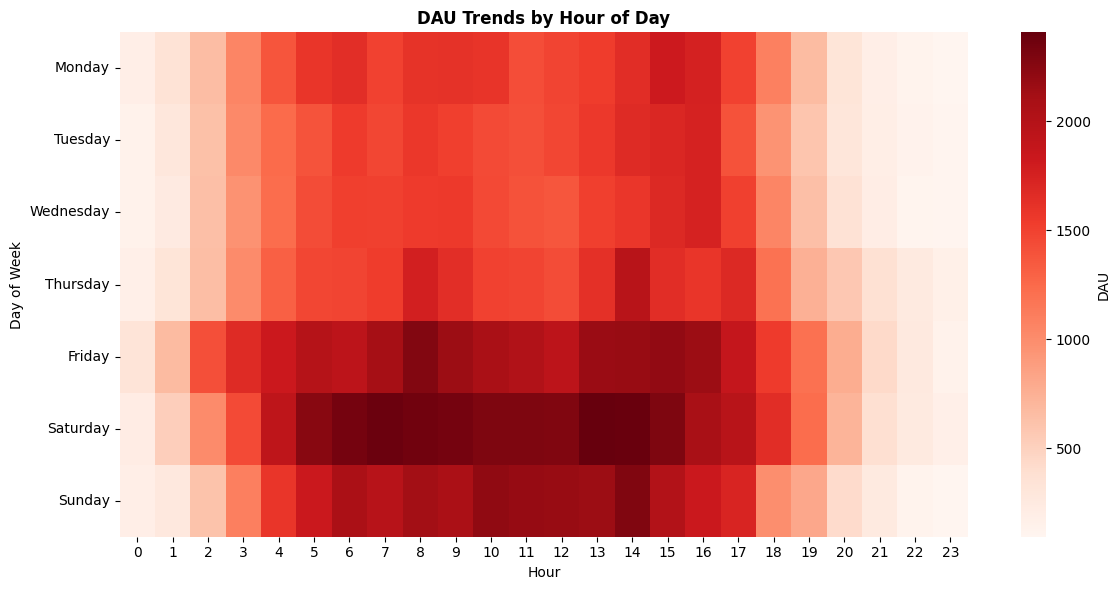

In [12]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_df = dau_hour.pivot(index='day_of_week', columns='hour', values='dau').reindex(day_order)

sns.heatmap(heatmap_df, annot=False, cmap='Reds', cbar_kws={'label':'DAU'})
plt.title('DAU Trends by Hour of Day', fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

The heatmap illustrates hourly user activity across different days of the week. DAU activity shows slight differences between weekdays and weekends.

On weekdays, DAU is higher in the afternoon, particularly from 2 PM to 5 PM, and relatively low during the rest of the day.

In contrast, on weekends (Friday, Saturday, and Sunday), DAU is more active from 4 AM to 5 PM. As mentioned previously, Saturday shows the most concentrated activity across different hours. One interesting finding is that user activity peaks early in the morning, from 6 AM to 2 PM, on Saturday.

Based on these patterns, different promotions could be applied at different time ranges throughout the week to better target users.

In [13]:
df.head()

,event_time,event_type,user_id,user_session,date_ymd,day_of_week,day_of_week1,hour,hour_group
0,2019-11-01 00:00:23,view,436701163,50de79b1-b0ec-42c0-bbe0-8b5d2dc33e1e,2019-11-01,Friday,4,0,Night(0-6)
1,2019-11-01 00:01:33,view,518956209,6764041a-9285-4869-8a32-a79adf31d212,2019-11-01,Friday,4,0,Night(0-6)
2,2019-11-01 00:02:04,view,541851324,bd3d2542-e845-48be-989a-0c9bc5ce1bea,2019-11-01,Friday,4,0,Night(0-6)
3,2019-11-01 00:02:11,view,518956209,6764041a-9285-4869-8a32-a79adf31d212,2019-11-01,Friday,4,0,Night(0-6)
4,2019-11-01 00:04:47,view,566281250,a79171eb-7d81-4536-8623-8f3159da5229,2019-11-01,Friday,4,0,Night(0-6)


In [14]:
dau_hour_average = df.groupby('hour_group')['user_id'].nunique().reset_index().rename(columns={'user_id':'dau'})
dau_hour_average

,hour_group,dau
0,Night(0-6),47992
1,Morning(6-12),68406
2,Afternoon(12-18),65634
3,Evening(18-24),12515


In [15]:
dau_hour_average['dau_ratio'] = (dau_hour_average['dau'] / dau_hour_average['dau'].sum() * 100).round(2)
dau_hour_average

,hour_group,dau,dau_ratio
0,Night(0-6),47992,24.67
1,Morning(6-12),68406,35.16
2,Afternoon(12-18),65634,33.74
3,Evening(18-24),12515,6.43


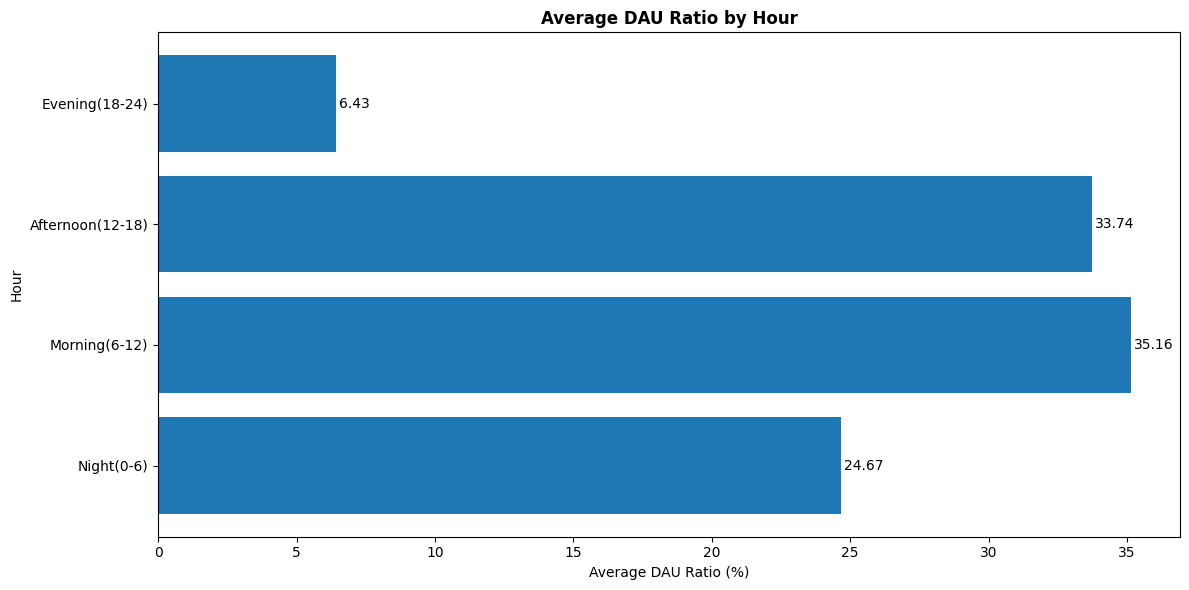

In [16]:
plt.barh(dau_hour_average['hour_group'], dau_hour_average['dau_ratio'])
plt.xlabel('Average DAU Ratio (%)')
plt.ylabel('Hour')
plt.title('Average DAU Ratio by Hour', fontweight='bold')

for i, v in enumerate(dau_hour_average['dau_ratio']):
  plt.text(v+0.1, i, str(v), ha='left', va='center')

plt.tight_layout()
plt.show()

The following bar plot represents the average DAU ratio by hour per day. Users are most active in the morning (6-12) with ratio of 35.16%, followed by the afternoon (12-18) with ratio of 33.74%. This pattern may be influenced by the relatively large number of active users during the weekend as most of them visit in the morning and afternoon.

## ▶ Funnel Analysis

In [17]:
df.head()

,event_time,event_type,user_id,user_session,date_ymd,day_of_week,day_of_week1,hour,hour_group
0,2019-11-01 00:00:23,view,436701163,50de79b1-b0ec-42c0-bbe0-8b5d2dc33e1e,2019-11-01,Friday,4,0,Night(0-6)
1,2019-11-01 00:01:33,view,518956209,6764041a-9285-4869-8a32-a79adf31d212,2019-11-01,Friday,4,0,Night(0-6)
2,2019-11-01 00:02:04,view,541851324,bd3d2542-e845-48be-989a-0c9bc5ce1bea,2019-11-01,Friday,4,0,Night(0-6)
3,2019-11-01 00:02:11,view,518956209,6764041a-9285-4869-8a32-a79adf31d212,2019-11-01,Friday,4,0,Night(0-6)
4,2019-11-01 00:04:47,view,566281250,a79171eb-7d81-4536-8623-8f3159da5229,2019-11-01,Friday,4,0,Night(0-6)


In [18]:
funnel = df.groupby('event_type')['user_session'].nunique().reindex(['view', 'cart', 'purchase']).reset_index()
funnel.columns = ['stage', 'unique_session']
funnel

,stage,unique_session
0,view,199863
1,cart,25037
2,purchase,11179


In [19]:
funnel['retention_rate'] = (funnel['unique_session'] / funnel['unique_session'].shift(1) * 100).fillna(100).round(2)
funnel['drop_off_rate'] = 100 - funnel['retention_rate'].round(2)
funnel

,stage,unique_session,retention_rate,drop_off_rate
0,view,199863,100.00,0.00
1,cart,25037,12.53,87.47
2,purchase,11179,44.65,55.35


In [22]:
# Conversion Funnel : Retention Rate

import plotly.express as px

fig = px.funnel(funnel, x='stage', y='retention_rate', title='2019 November E-Commerce Conversion Funnel', labels={'stage':'Stage', 'retention__rate':'Retention Rate'})
fig.update_traces(texttemplate='%{y}%', textposition='inside')
fig.show()

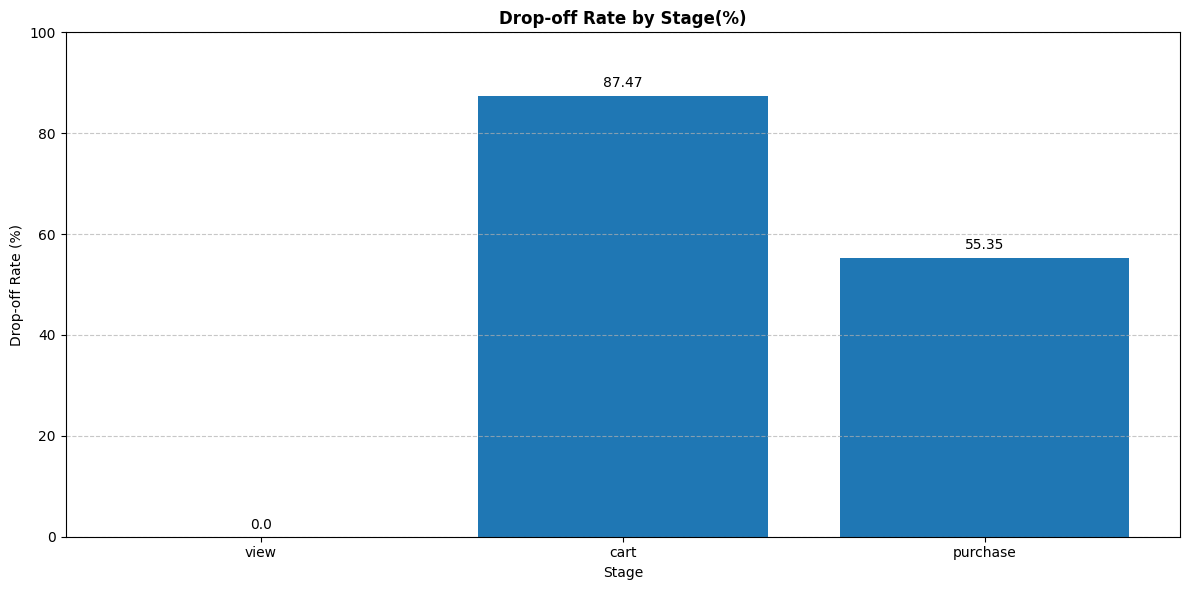

In [21]:
# Conversion Funnel : Drop-off Rate

plt.bar(funnel['stage'], funnel['drop_off_rate'])

for i, v in enumerate(funnel['drop_off_rate']):
  plt.text(i, v+1, str(v), ha='center', va='bottom')

plt.title('Drop-off Rate by Stage(%)', fontweight='bold')
plt.xlabel('Stage')
plt.ylabel('Drop-off Rate (%)')
plt.ylim((0, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From the graphs above, 87.47% of users dropped off from 'View' to 'Cart'. In contrast, the drop-off rate from 'Cart' to 'Purchase' is 55.35%.

This suggests that once users add items to their cart, there is a relatively high likelihood that they will proceed to purchase. However, the transition to the 'Cart' stage is not occurring effectively, indicating that immediate improvements are needed to encourage users to add items to their cart.

# **Summary**

# Key Findings

* DAU Trends by Day of Week : 🥇Saturday (35,148) 🥈Friday (33,318) 🥉Sunday (29,593)
* Average DAU Ratio by Hour : 🥇Morning(6-12) (35.16%) 🥈Afternoon(12-18) (33.74%)
  * Highly affected by users from weekend. Most active from 6 AM to 2 PM.
* Drop-off Rate :
  * View ➡ Cart (87.47%)
  * Cart ➡ Purchase (55.35%)

# Insights

1. Strong sale promotions could be applied during the weekend between 6 AM to 2 PM.
2. Weekend-focused users are likely to be workers. Banner pormotions should feature category items targeted toward this user segment.
3. Introduce quick-commerce cues by displaying delivery assurance messages such as "Order now, arrive by tomorrow".
4. Strenthen review and rating visibility by placing top review on the product page to build trust and reduce drop-off before the cart stage.
5. Provide personalized benefits, such as additional 3% discount coupon for cart items.